## Web Coverage Service - Accessing GeoMet data using owslib

In this notebook we'll connect to Environment Canada's GeoMet service and fetch data using the WCS standard. 

In [1]:
%matplotlib inline

from owslib.wcs import WebCoverageService
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# NBVAL_IGNORE_OUTPUT
wcs_url = 'http://geo.weather.gc.ca/geomet/?lang=en&service=WCS'

# Connect to service
wcs = WebCoverageService(wcs_url, version='2.0.1')
print(wcs.identification.title)

# List some of the content available
sorted(list(wcs.contents.keys()))[:10]

MSC GeoMet — GeoMet-Weather 2.12.2


['GDPS.CONV_KINDEX.PT3H',
 'GDPS.CONV_KINDEX.PT6H',
 'GDPS.CONV_ML-LCL-HGT.3h',
 'GDPS.CONV_ML-LCL-HGT.6h',
 'GDPS.CONV_ML-LI.400.3h',
 'GDPS.CONV_ML-LI.400.6h',
 'GDPS.CONV_ML-LI.500.3h',
 'GDPS.CONV_ML-LI.500.6h',
 'GDPS.CONV_ML-LI.600.3h',
 'GDPS.CONV_ML-LI.600.6h']

Now let's get some information about a given layer, here the salinity. 

In [3]:
layerid = 'OCEAN.GIOPS.3D_SALW_0000'
temp = wcs[layerid]
#Title
print('Layer title :', temp.title)
#bounding box
print('BoundingBox :', temp.boundingBoxWGS84)
# supported data formats - we'll use geotiff
print('Formats :', temp.supportedFormats)
#grid dimensions
print('Grid upper limits :', temp.grid.highlimits)

Layer title : None
BoundingBox : None
Formats : ['image/tiff', 'image/x-aaigrid', 'image/netcdf', 'image/png', 'image/jpeg', 'image/png; mode=8bit', 'image/vnd.jpeg-png', 'image/vnd.jpeg-png8']
Grid upper limits : ['1799', '849']


To request data, we need to call the `getCoverage` service, which requires us specifying the geographic projection, the bounding box, the resolution and format of the output. With GeoMet 2.0.1, we can now get layers in the netCDF format. 

In [4]:
format_wcs = 'image/netcdf'
bbox_wcs = temp.boundingboxes[0]['bbox'] # Get the entire domain
crs_wcs = temp.boundingboxes[0]['nativeSrs'] # Coordinate system
w = int(temp.grid.highlimits[0] )
h = int(temp.grid.highlimits[1])

print("Format:", format_wcs)
print("Bounding box:", bbox_wcs)
print("Projection:", crs_wcs)
print("Resolution: {} x {}".format(w, h))

output = wcs.getCoverage(identifier=[layerid, ], crs=crs_wcs, bbox=bbox_wcs, width=w, height=h, format=format_wcs)

Format: image/netcdf
Bounding box: (-80.1, -180.0, 89.9, 180.0)
Projection: http://www.opengis.net/def/crs/EPSG/0/4326
Resolution: 1799 x 849


We then save the output to disk, open it normally using xarray and plot it's variable. 

In [5]:
fn = layerid + '.nc'
with open(fn, 'wb') as fh:
    fh.write(output.read())

Data variables:
    crs      |S1 ...
    Band1    (lat, lon) float32 ...


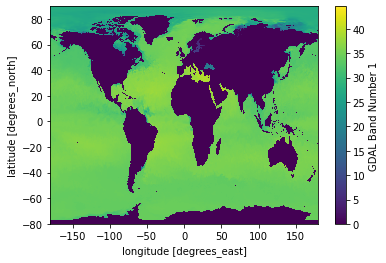

In [6]:
ds = xr.open_dataset(fn)
print(ds.data_vars)
ds.Band1.plot()
plt.show()